In [2]:
import torch
import norse
from norse.torch.functional.lif_adex import LIFAdExParameters
import norse.torch as snn
import torch.nn as nn
from tqdm import tqdm
from generate_tasks.cognitive_task import ContextDM, CompareObjects, WorkingMemory, MultyTask
from exponent_filter import ExpFilter
import matplotlib.pyplot as plt
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(f'Device: {("gpu (cuda)" if device.type=="cuda" else "cpu")}')

#print(neuron_parameters)
class SNNMULTYTASK(torch.nn.Module):
    def __init__(self, feature_size, hidden_size, output_size, neuron_parameters) -> None:
        super(SNNMULTYTASK, self).__init__()
        #self.poisson = snn.PoissonEncoder(100)
        #self.lif0 = snn.LIFRecurrent(feature_size, hidden_size)
        self.alif = snn.LIFAdExRecurrent(feature_size, hidden_size, p=neuron_parameters)
        #self.lif = snn.LIFRecurrent(feature_size, hidden_size)
        self.exp_f = ExpFilter(hidden_size, output_size, 0.8)
        #self.linear = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        #out, state = self.lif0(x) 
        out, state = self.alif(x)
       #out = self.linear(out) 
        out = self.exp_f(out)       
        return (out, state)
        

    

Device: cpu


In [3]:

import numpy as np
# 0. Create dataset


batch_size = 10
task_list = [('WorkingMemory', dict()),
             (('ContextDM', dict()))]
tasks = dict(task_list)
CDM_task = MultyTask(tasks, batch_size=batch_size)
#inputs, labels, ob_size, act_size = CDM_task.dataset()


feature_size, output_size = CDM_task.feature_and_act_size[0]
hidden_size = 200

# 1. model


neuron_parameters = LIFAdExParameters(tau_ada_inv=torch.Tensor([2]).to(device), alpha=100)
model = SNNMULTYTASK(feature_size, hidden_size, output_size, neuron_parameters).to(device)
with torch.no_grad():
    weights_pre_l = []
    for name, param in model.named_parameters(): 
        if param.requires_grad: 
            weights_pre_l.append((param).cpu().numpy())
            #print (name, param.data)

# 2. loss and optimizer
learning_rate = 5e-3
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))
criterion = nn.MSELoss()
criterion_test = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.8, 0.85))
running_loss = 0.0



In [4]:
# 3. train loop
%matplotlib
#fig, ax = plt.subplots()
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
inputs, target_outputs = CDM_task.dataset(10)
line1, = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 1], 'b-')
line2, = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 2], 'r-')
line3, = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 1], 'b-')
line4, = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 2], 'r-')
ax.set_ylim([-.5, 1.5])
ax.set_xlim([0, 20000])
for i in tqdm(range(1000)):
    inputs, target_outputs = CDM_task.dataset(10)
    inputs += np.random.normal(0, .1, size=(inputs.shape))
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)  
    target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, states = model(inputs)
    
    loss = criterion(outputs, target_outputs)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 10 == 9:
        print('epoch: {:d} loss: {:0.5f}'.format(i + 1, running_loss / 10))
        running_loss = 0.0
        with torch.no_grad():
            inputs, target_outputs = CDM_task.dataset(10)
            
            inputs = torch.from_numpy(inputs).type(torch.float).to(device)  
            target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
            outputs, states = model(inputs)
            loss = criterion_test(outputs, target_outputs)
            

            

            
            
            print('test loss: {:0.5f}'.format(loss.item()))
        for_plot =  outputs.detach().cpu().numpy()[:, 0, :]
        line1.set_xdata(np.arange(0, len(for_plot), 1))
        line2.set_xdata(np.arange(0, len(for_plot), 1))
        line3.set_xdata(np.arange(0, len(for_plot), 1))
        line4.set_xdata(np.arange(0, len(for_plot), 1))
        line1.set_ydata(for_plot[:, 1])
        
        #line1.set_xdata(np.arange(0, len(for_plot)))
        line2.set_ydata(for_plot[:, 2])
        line3.set_ydata(target_outputs.detach().cpu().numpy()[:, 0, 1])
        line4.set_ydata(target_outputs.detach().cpu().numpy()[:, 0, 2])
        #line2.set_xdata(np.arange(0, len(for_plot)))
    fig.canvas.draw()
    fig.canvas.flush_events()
            
            
        
       

print('Finished Training')


Using matplotlib backend: TkAgg


  1%|          | 9/1000 [02:07<3:51:15, 14.00s/it]

epoch: 10 loss: 0.16179


  1%|          | 10/1000 [02:26<4:18:53, 15.69s/it]

test loss: 0.10467


In [ ]:
fig, ax = plt.subplots()
for i in range(100):
    x = np.arange(100)
    y = np.full([100], fill_value=i)
    plot_something_live(ax,  y)

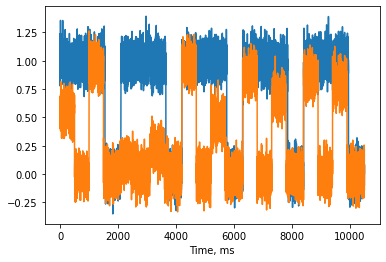

inputs.shape = (10500, 1, 2)
outputs.shape = (10500, 1, 3)


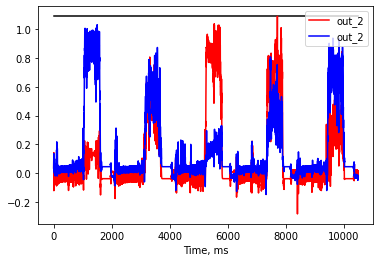

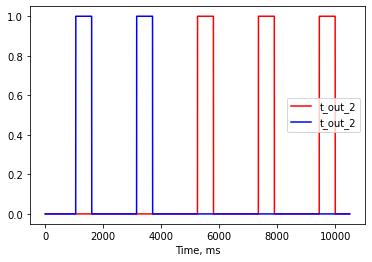

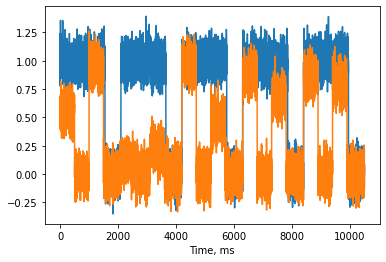

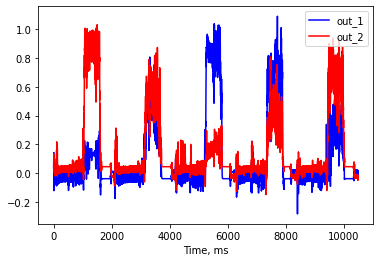

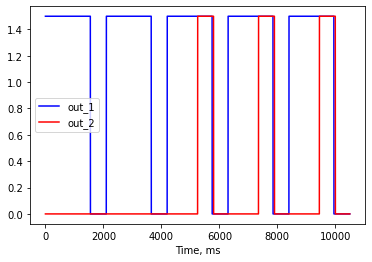

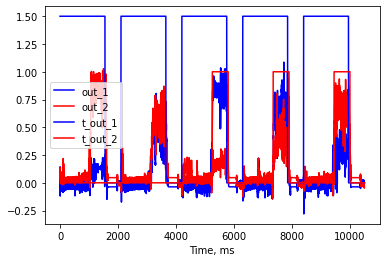

In [ ]:

# 0. Create dataset
%matplotlib inline
dt = 1e-3

batch_size = 1
CDM_task = WorkingMemory(batch_size=batch_size)
inputs, labels = CDM_task.dataset(5)
inputs += np.random.normal(0, .1, size=(inputs.shape))
plt.plot(inputs[:, 0, 0])
plt.plot(inputs[:, 0, 1])
plt.xlabel('Time, ms')
plt.show()
plt.close()
inputs = torch.from_numpy(inputs).type(torch.float).to(device)  
feature_size, output_size = CDM_task.feature_and_act_size

# 1. model

if False:
    
    model = SNNMULTYTASK(feature_size, hidden_size, output_size).to(device)
    with torch.no_grad():
        for name, param in model.named_parameters(): 
            param.copy_(torch.from_numpy( np.load(f'./data/{name}.npy')).to(device))
#labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)
with torch.no_grad():
    outputs, state = model(inputs)
    inputs = inputs.cpu().numpy() 
    outputs = outputs.cpu().numpy()
    print(f'inputs.shape = {inputs.shape}')
    print(f'outputs.shape = {outputs.shape}')
    plt.plot([0, len(labels)], [np.max(outputs[:, 0, 1])] * 2, c='black')
    plt.plot(outputs[:, 0, 1], label='out_2', c='r')
    plt.plot(outputs[:, 0, 2], label='out_2', c='b')
    plt.xlabel('Time, ms')
    plt.legend()
    plt.show()
    plt.close()
    plt.plot(labels[:, 0, 1]  , label='t_out_2', c='r')
    plt.plot(labels[:, 0, 2]  , label='t_out_2', c='b')
    plt.xlabel('Time, ms')
    plt.legend()
    plt.show()
    plt.close()
    #plt.plot(labels[:, 0, 0])
    plt.plot(inputs[:, 0, 0])
    plt.plot(inputs[:, 0, 1])
    #plt.xlim([0, 1000])
    plt.xlabel('Time, ms')
    plt.show()
    plt.close()
    #plt.plot(outputs[:, 0, 2])
    #plt.plot(outputs[:, 0, 0] + 1)
    plt.plot(outputs[:, 0, 1], label='out_1', c='b')
    plt.plot(outputs[:, 0, 2], label='out_2', c='r')
    plt.xlabel('Time, ms')
    plt.legend()
    plt.show()
    plt.close()
    plt.plot(labels[:, 0, 0] * 1.5 , label='out_1', c='b')
    plt.plot(labels[:, 0, 1] * 1.5 , label='out_2', c='r')
    #plt.xlim([0, 300])
    plt.xlabel('Time, ms')
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(outputs[:, 0, 1], label='out_1', c='b')
    plt.plot(outputs[:, 0, 2], label='out_2', c='r')

    plt.plot(labels[:, 0, 0] * 1.5 , label='t_out_1', c='b')
    plt.plot(labels[:, 0, 1]  , label='t_out_2', c='r')
    plt.xlabel('Time, ms')
    plt.legend()
    plt.show()
    plt.close()

    


In [ ]:
torch.save(model.state_dict(), './saved_models/1_0_working_memory')